In [11]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from oggm import utils, cfg
cfg.initialize()

import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 8)

2021-11-30 15:56:21: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-11-30 15:56:21: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-11-30 15:56:21: oggm.cfg: Multiprocessing: using all available processors (N=32)


In [12]:
import seaborn as sns
sns.set_context('talk')

In [13]:
period = '2000-01-01_2020-01-01'

dfz = pd.read_csv(utils.get_demo_file('zemp_ref_2006_2016.csv'), index_col=0)
dfh = pd.read_csv(utils.get_demo_file('table_hugonnet_regions_10yr_20yr_ar6period.csv'), index_col=0)
dfh = dfh.loc[dfh.period == period]

In [14]:
dfz['SMB_ZEMP'] = dfz['SMB']
dfz['SMB_HUGUONNET'] = dfh['dmdtda'] * 1e-3
dfz['SMB_HUGUONNET_err'] = dfh['err_dmdtda'] * 1e-3
dfz.index = ['{:02d}'.format(rgi_reg) for rgi_reg in dfz.index]

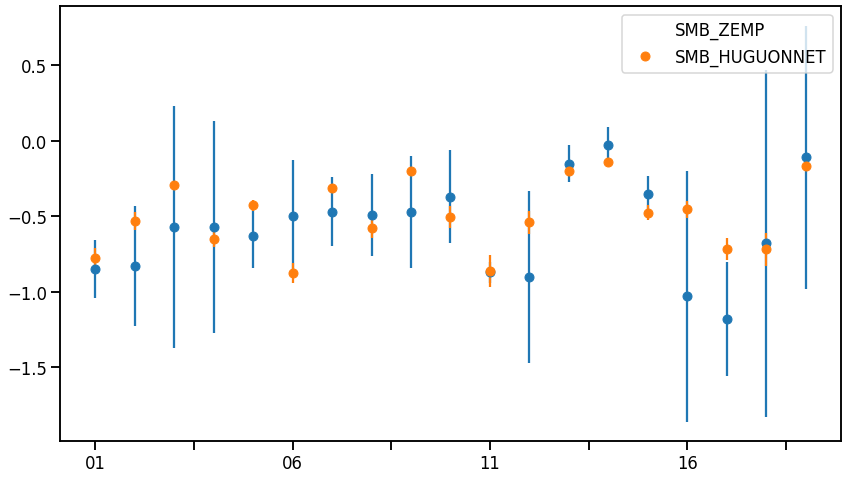

In [15]:
f, ax = plt.subplots()
dfz.plot(ax=ax, y='SMB_ZEMP', yerr='SMB_err', marker='o', linestyle='none');
dfz.plot(ax=ax, y='SMB_HUGUONNET', yerr='SMB_HUGUONNET_err', marker='o', linestyle='none');

In [16]:
dfh['dmdt_zemp'] = dfz.SMB.values * 1000
dfh['dmdt_zemp_err'] = dfz.SMB_err.values * 1000

In [17]:
dfh.index = ['{:02d}'.format(int(rgi_reg)) for rgi_reg in dfh.index]

In [18]:
path = '/home/www/oggm/gdirs/oggm_v1.4/'
odirs = [f'{path}/L3-L5_files/ERA5/elev_bands/qc3/pcp1.6/no_match/RGI62/b_160/L3/summary/',
         f'{path}/L3-L5_files/ERA5/elev_bands/qc3/pcp1.6/match_geod/RGI62/b_160/L3/summary/',
         f'{path}/L3-L5_files/ERA5/elev_bands/qc3/pcp1.6/match_geod_pergla/RGI62/b_160/L3/summary/',
        ]
names = ['old', 'regio', 'pergla'
        ]         

for odir, name in zip(odirs, names):
    for rgi_reg in np.arange(1, 20):
        rgi_reg = '{:02d}'.format(rgi_reg)

        try:
            df = pd.read_csv(odir + f'fixed_geometry_mass_balance_{rgi_reg}.csv'.format(rgi_reg), index_col=0, low_memory=False)
            dfs = pd.read_csv(odir + f'glacier_statistics_{rgi_reg}.csv'.format(rgi_reg), index_col=0, low_memory=False)
        except FileNotFoundError:
            print('Not here:', odir, rgi_reg)
            continue
        df = df.dropna(axis=0, how='all')
        df = df.dropna(axis=1, how='all')

#         odf = pd.DataFrame(df.loc[2006:2016].mean(), columns=['SMB'])
#         odf['AREA'] = dfs.rgi_area_km2

#         dfh.loc[rgi_reg, 'AREA_OGGM'] = odf['AREA'].sum()
#         dfh.loc[rgi_reg, 'SMB_OGGM'] = np.average(odf['SMB'], weights=odf['AREA']) / 1000

        odf = pd.DataFrame(df.loc[2000:].mean(), columns=['SMB'])
        odf['AREA'] = dfs.rgi_area_km2
        dfh.loc[rgi_reg, f'dmdtda_OGGM_{name}'] = np.average(odf['SMB'], weights=odf['AREA'])
        
        
        odir_5 = odir.replace('L3/', 'L5/')
        
        with xr.open_dataset(odir_5 + f'historical_run_output_extended_{rgi_reg}.nc') as ds:
            ds = ds[['volume', 'area']].sum(dim='rgi_id')
        vol_ts = ds.volume.to_series()
        area_ts = ds.area.to_series()
        dfh.loc[rgi_reg, f'dmdt_OGGM_{name}'] = (vol_ts.loc[2019] - vol_ts.loc[2000]) * cfg.PARAMS['ice_density'] * 1e-12 / 20
        dfh.loc[rgi_reg, f'dmdtda_dyna_OGGM_{name}'] = (vol_ts.loc[2019] - vol_ts.loc[2000]) / area_ts.loc[2000] * cfg.PARAMS['ice_density'] / 20 

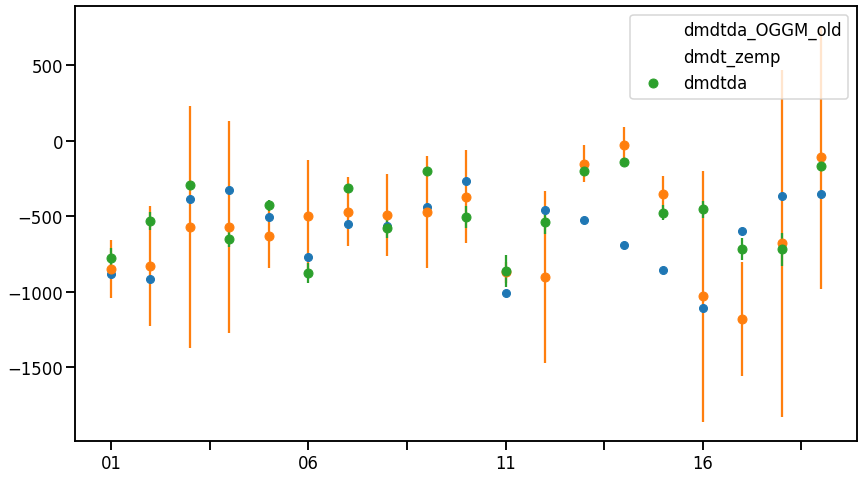

In [19]:
f, ax = plt.subplots()
dfh.plot(ax=ax, y='dmdtda_OGGM_old', marker='o', linestyle='none', markersize=8);
dfh.plot(ax=ax, y='dmdt_zemp', yerr='dmdt_zemp_err', marker='o', linestyle='none');
dfh.plot(ax=ax, y='dmdtda', yerr='err_dmdtda', marker='o', linestyle='none');

In [20]:
dfh[['dmdtda', 'dmdt_zemp', 'dmdtda_OGGM_old']].mean()

dmdtda            -495.951579
dmdt_zemp         -581.578947
dmdtda_OGGM_old   -608.398797
dtype: float64

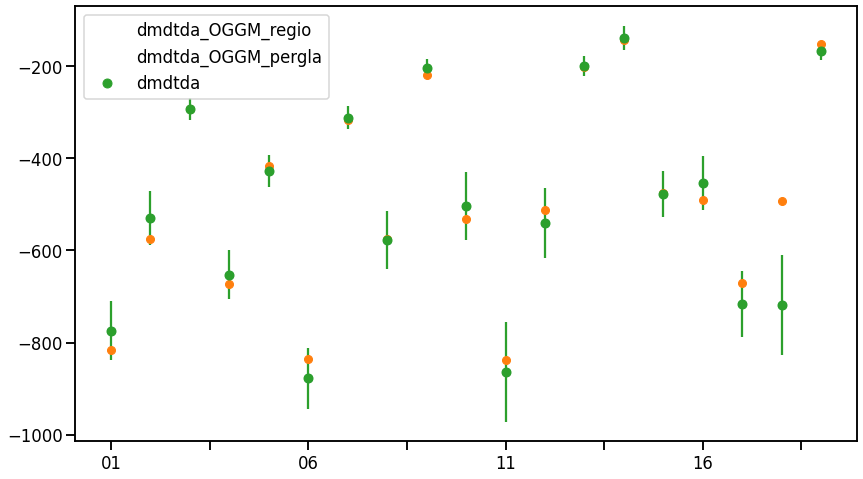

In [21]:
f, ax = plt.subplots()
dfh.plot(ax=ax, y='dmdtda_OGGM_regio', marker='o', linestyle='none', markersize=8);
dfh.plot(ax=ax, y='dmdtda_OGGM_pergla', marker='o', linestyle='none', markersize=8);
dfh.plot(ax=ax, y='dmdtda', yerr='err_dmdtda', marker='o', linestyle='none');

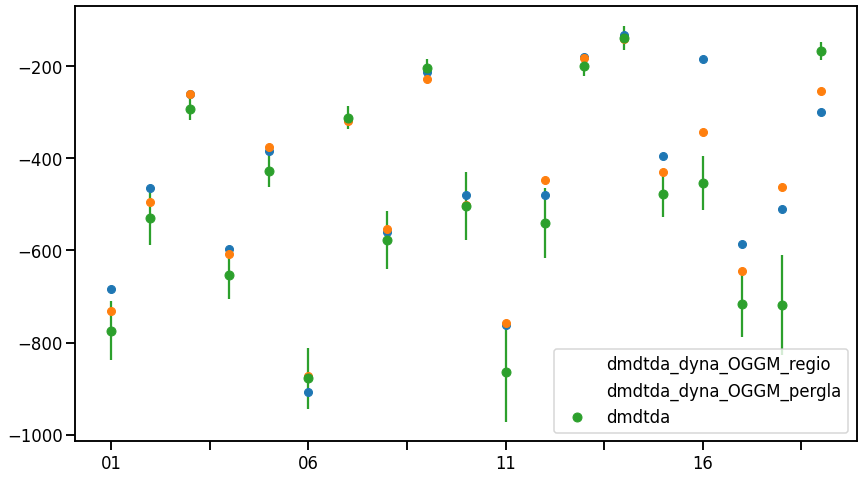

In [22]:
f, ax = plt.subplots()
dfh.plot(ax=ax, y='dmdtda_dyna_OGGM_regio', marker='o', linestyle='none', markersize=8);
dfh.plot(ax=ax, y='dmdtda_dyna_OGGM_pergla', marker='o', linestyle='none', markersize=8);
dfh.plot(ax=ax, y='dmdtda', yerr='err_dmdtda', marker='o', linestyle='none');

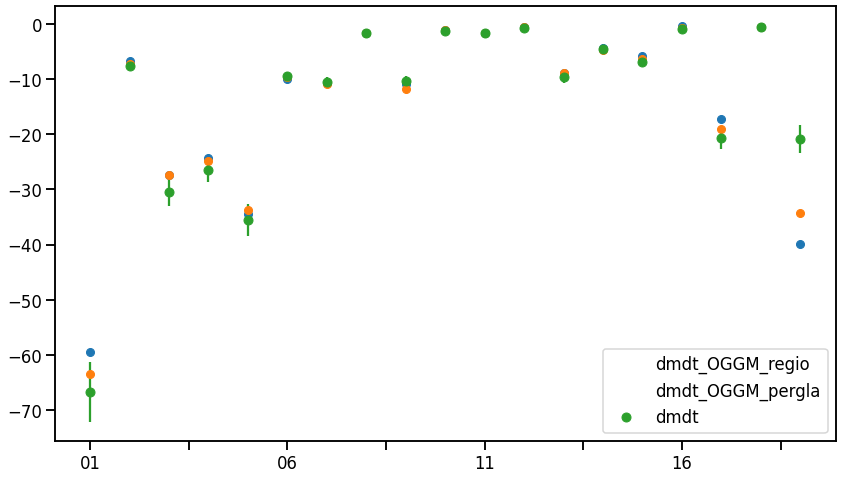

In [23]:
f, ax = plt.subplots()
dfh.plot(ax=ax, y='dmdt_OGGM_regio', marker='o', linestyle='none', markersize=8);
dfh.plot(ax=ax, y='dmdt_OGGM_pergla', marker='o', linestyle='none', markersize=8);
dfh.plot(ax=ax, y='dmdt', yerr='err_dmdt', marker='o', linestyle='none');

In [24]:
dfh.columns

Index(['period', 'dmdt', 'err_dmdt', 'dmdtda', 'err_dmdtda', 'dmdt_zemp',
       'dmdt_zemp_err', 'dmdtda_OGGM_old', 'dmdt_OGGM_old',
       'dmdtda_dyna_OGGM_old', 'dmdtda_OGGM_regio', 'dmdt_OGGM_regio',
       'dmdtda_dyna_OGGM_regio', 'dmdtda_OGGM_pergla', 'dmdt_OGGM_pergla',
       'dmdtda_dyna_OGGM_pergla'],
      dtype='object')

In [25]:
dfh[['dmdtda', 'dmdtda_OGGM_old', 'dmdtda_OGGM_regio', 'dmdtda_OGGM_pergla']].corr()

dmdtda  dmdtda_OGGM_old  dmdtda_OGGM_regio  \
dmdtda              1.000000         0.334927           1.000000   
dmdtda_OGGM_old     0.334927         1.000000           0.334927   
dmdtda_OGGM_regio   1.000000         0.334927           1.000000   
dmdtda_OGGM_pergla  0.968575         0.423244           0.968575   

                    dmdtda_OGGM_pergla  
dmdtda                        0.968575  
dmdtda_OGGM_old               0.423244  
dmdtda_OGGM_regio             0.968575  
dmdtda_OGGM_pergla            1.000000

In [26]:
dfh[['dmdt', 'dmdt_OGGM_old', 'dmdt_OGGM_regio', 'dmdt_OGGM_pergla']].sum()

dmdt               -266.380000
dmdt_OGGM_old      -361.180263
dmdt_OGGM_regio    -266.220926
dmdt_OGGM_pergla   -268.440202
dtype: float64

## Quick check area volume 

In [ ]:
path = '/home/www/oggm/gdirs/oggm_v1.4'
dd = f'{path}/L3-L5_files'

fd = f'{dd}/ERA5/elev_bands/qc3/pcp1.6/no_match/RGI62/b_080/L5/summary/glacier_statistics_11.csv'
df = pd.read_csv(fd, index_col=0, low_memory=False)

In [ ]:
fd = f'{dd}/ERA5/elev_bands/qc3/pcp1.6/no_match/RGI62/b_080/L5/summary/historical_run_output_extended_11.nc'
ds = xr.open_dataset(fd)

In [ ]:
ds.volume.sum(dim='rgi_id').plot();


In [ ]:
check = ds.area.isel(time=0).to_dataframe()[['area']]

In [ ]:
check = ds.area.isel(time=0).to_dataframe()[['area']]

In [ ]:
check = check.dropna()

In [ ]:
check.sum()

In [ ]:
check.loc[~ np.isclose(check.area_rgi, check.area)]

In [ ]:
np.testing.assert_allclose(check.area_rgi, check.area, rtol=3e-2)

In [ ]:
#### check inversion volume

In [ ]:
fd = f'{dd}/CRU/centerlines/qc3/pcp2.5/no_match/RGI62/b_080/L3/summary/'
fs = glob.glob(fd+'glacier_statistics*.csv')
assert len(fs) == 18 # 17 @Fabi this is now 18!!! 

In [ ]:
df = []
for f in fs:
    df.append(pd.read_csv(f, index_col=0, low_memory=False))
df = pd.concat(df).sort_index()

In [ ]:
dfv = df[['inv_volume_km3']].dropna()

In [ ]:
df_ref = pd.read_hdf(utils.get_demo_file('rgi62_itmix_df.h5'))

In [ ]:
dfv['ref'] = df_ref.loc[dfv.index]['vol_itmix_m3'] * 1e-9

In [ ]:
dfv.sum()

In [ ]:
len(dfv)